# Stock Price Prediction for Apple 

### Import libraries

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

### Data Pre-processing

In [2]:
data=pd.read_csv('AAPL.csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2003-11-10,0.400893,0.404464,0.390000,0.391071,0.331503,234276000
1,2003-11-11,0.391071,0.393214,0.383571,0.384643,0.326054,215073600
2,2003-11-12,0.383571,0.405714,0.383571,0.398750,0.338012,300003200
3,2003-11-13,0.394107,0.402857,0.391429,0.400357,0.339375,212772000
4,2003-11-14,0.401429,0.403750,0.380000,0.383214,0.324843,237048000


In [3]:
data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
5030,2023-11-03,174.240005,176.820007,173.350006,176.649994,176.417572,79763700
5031,2023-11-06,176.380005,179.429993,176.210007,179.229996,178.994186,63841300
5032,2023-11-07,179.179993,182.440002,178.970001,181.820007,181.580780,70530000
5033,2023-11-08,182.350006,183.449997,181.589996,182.889999,182.649368,49340300
5034,2023-11-09,182.960007,184.119995,181.809998,182.410004,182.169998,53763500


In [4]:
data.shape

(5035, 7)

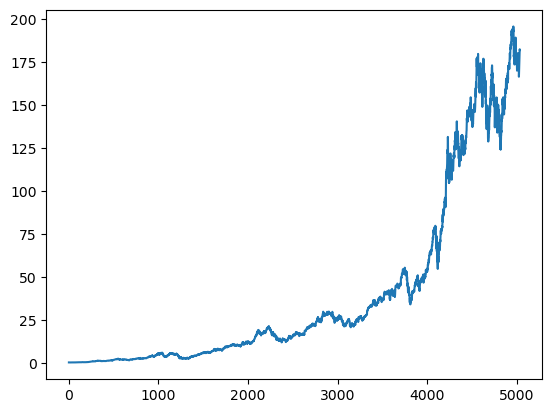

In [5]:
plt.plot(data['Adj Close'])

In [6]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,5035.000000,5035.000000,5035.000000,5035.000000,5035.000000,5.035000e+03
mean,41.581368,42.040325,41.141793,41.610186,40.056348,4.084786e+08
std,51.772013,52.369294,51.225361,51.824673,51.748527,3.959992e+08
min,0.350893,0.355179,0.343750,0.351786,0.298202,3.145820e+07
25%,5.563392,5.666429,5.461429,5.563035,4.715672,1.140306e+08
50%,20.981787,21.195356,20.717501,20.913214,17.849108,2.752512e+08
75%,47.111250,47.517499,46.721249,47.156250,45.196321,5.759642e+08
max,196.240005,198.229996,195.279999,196.449997,195.926956,3.372970e+09


In [7]:
adfuller(data['Adj Close'])  

(1.5549796329250603,
 0.997716023996494,
 30,
 5004,
 {'1%': -3.431657485549286,
  '5%': -2.862117767330564,
  '10%': -2.567077546233197},
 16008.386629978731)

<Axes: >

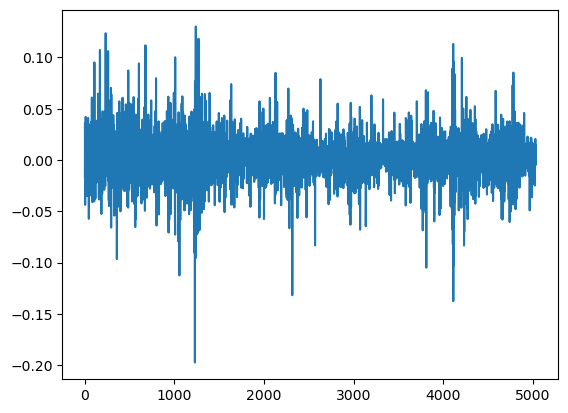

In [8]:
np.log(data['Adj Close']).diff().plot()

In [9]:
data1=data['Adj Close'].diff(1).dropna()

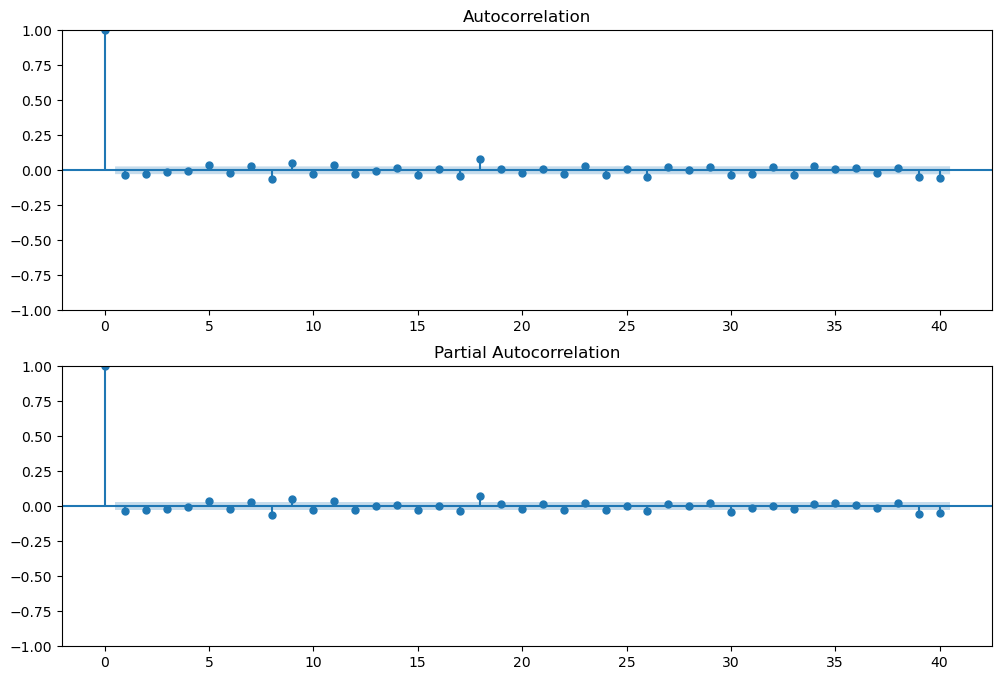

In [10]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data1, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data1, lags=40, ax=ax2, method='ywm')

In [11]:
adfuller(data1)   

(-13.258563735701136,
 8.489298593745246e-25,
 29,
 5004,
 {'1%': -3.431657485549286,
  '5%': -2.862117767330564,
  '10%': -2.567077546233197},
 16006.628368438527)

In [12]:
def data_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = [], []
    
    #input sequence(t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('adj_close%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    
    #forecast sequence(t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('adj_close%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('adj_close%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    
    data = pd.concat(cols, axis=1)
    data.columns = names
    
    # drop NaN values
    if dropnan:
        data.dropna(inplace=True)
    return data

In [13]:

scaler = StandardScaler()
data2=scaler.fit_transform(data1.values.reshape(-1,1))

scaler1 = StandardScaler()
data3=scaler1.fit_transform(data['Adj Close'].values.reshape(-1,1))

In [14]:
new_data=pd.DataFrame(data3,columns=['diff'])
new_data

,diff
0,-0.767728
1,-0.767833
2,-0.767602
3,-0.767576
4,-0.767857
...,...
5030,2.635336
5031,2.685132
5032,2.735121
5033,2.755773


In [15]:
newdata = data_to_supervised(new_data, 1, 7)
newdata.head()

,adj_close1(t-1),adj_close1(t),adj_close1(t+1),adj_close1(t+2),adj_close1(t+3),adj_close1(t+4),adj_close1(t+5),adj_close1(t+6)
1,-0.767728,-0.767833,-0.767602,-0.767576,-0.767857,-0.767953,-0.768164,-0.768161
2,-0.767833,-0.767602,-0.767576,-0.767857,-0.767953,-0.768164,-0.768161,-0.768173
3,-0.767602,-0.767576,-0.767857,-0.767953,-0.768164,-0.768161,-0.768173,-0.768202
4,-0.767576,-0.767857,-0.767953,-0.768164,-0.768161,-0.768173,-0.768202,-0.767947
5,-0.767857,-0.767953,-0.768164,-0.768161,-0.768173,-0.768202,-0.767947,-0.768085


In [16]:
X = newdata.iloc[:,:-1].values
y = newdata.iloc[:,-1].values

train_size = int(len(newdata) * 0.8)
valid_size = int(len(newdata) * 0.1)
test_size = len(newdata) - train_size - valid_size



X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=(valid_size + test_size)/len(newdata),shuffle=False)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=test_size/(valid_size + test_size), shuffle=False)

# Convert to PyTorch tensors
X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)
X_valid, y_valid = torch.tensor(X_valid, dtype=torch.float32), torch.tensor(y_valid, dtype=torch.float32)
X_test, y_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)



In [17]:
batch_size=64
X_train = X_train.unsqueeze(1)
X_valid = X_valid.unsqueeze(1)
X_test = X_test.unsqueeze(1)


train_loader =  torch.utils.data.DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=False)
valid_loader =  torch.utils.data.DataLoader(TensorDataset(X_valid, y_valid), batch_size=batch_size, shuffle=False)
test_loader =  torch.utils.data.DataLoader(TensorDataset(X_test, y_test), batch_size=1, shuffle=False)

In [18]:
print('X_train Shape: ', X_train.shape)
print('y_train Shape: ', y_train.shape)
print('X_valid Shape: ', X_valid.shape)
print('y_valid Shape: ', y_valid.shape)
print('X_test Shape:  ', X_test.shape)
print('y_test Shape:  ', y_test.shape)

X_train Shape:  torch.Size([4022, 1, 7])
y_train Shape:  torch.Size([4022])
X_valid Shape:  torch.Size([502, 1, 7])
y_valid Shape:  torch.Size([502])
X_test Shape:   torch.Size([504, 1, 7])
y_test Shape:   torch.Size([504])


### Model 

In [19]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNNModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 128)
        self.fc1 = nn.Linear(128, output_dim)
        self.drop = nn.Dropout(p=0.2)
        self.relu = nn.ReLU()

    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
        out, _ = self.rnn(x, h0.detach())
        out = self.fc(out[:, -1, :])
        out = self.fc1(out)
        return out

In [20]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.rnn = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 128)
        self.fc1 = nn.Linear(128, output_dim)
        self.drop = nn.Dropout(p=0.2)
        self.relu = nn.ReLU()

    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
        out, _ = self.rnn(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        out = self.fc1(out)
        return out

In [21]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, layer_size, output_size):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.layer_size = layer_size
        self.rnn = nn.GRU(input_size, hidden_size, layer_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 128)
        self.fc1 = nn.Linear(128, output_size)
        self.drop = nn.Dropout(p=0.2)
        self.relu = nn.ReLU()

    def forward(self, x):
        h0 = torch.zeros(self.layer_size, x.size(0), self.hidden_size).requires_grad_()
        out, _ = self.rnn(x, h0.detach())
        out = self.fc(out[:, -1, :])
        out = self.fc1(out)
        return out

In [22]:
input_size = X_train.shape[-1]
hidden_size = 100
layer_size = 1
output_size = 1

In [23]:
rnn_model = RNNModel(input_size, hidden_size, layer_size, output_size)
lstm_model = LSTMModel(input_size, hidden_size, layer_size, output_size)
gru_model = GRUModel(input_size, hidden_size, layer_size, output_size)

In [24]:
rnn_model

RNNModel(
  (rnn): RNN(7, 100, batch_first=True)
  (fc): Linear(in_features=100, out_features=128, bias=True)
  (fc1): Linear(in_features=128, out_features=1, bias=True)
  (drop): Dropout(p=0.2, inplace=False)
  (relu): ReLU()
)

In [25]:
gru_model

GRUModel(
  (rnn): GRU(7, 100, batch_first=True)
  (fc): Linear(in_features=100, out_features=128, bias=True)
  (fc1): Linear(in_features=128, out_features=1, bias=True)
  (drop): Dropout(p=0.2, inplace=False)
  (relu): ReLU()
)

In [26]:
lstm_model

LSTMModel(
  (rnn): LSTM(7, 100, batch_first=True)
  (fc): Linear(in_features=100, out_features=128, bias=True)
  (fc1): Linear(in_features=128, out_features=1, bias=True)
  (drop): Dropout(p=0.2, inplace=False)
  (relu): ReLU()
)

### Model Evaluation

In [27]:
def train_and_validate(model, train_loader, valid_loader, num_epochs):

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)


    train_losses = []
    valid_losses = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for data, target in train_loader:

            optimizer.zero_grad()

            output = model(data)

            loss = criterion(output, target.unsqueeze(1))
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * data.size(0)

        train_loss = train_loss / len(train_loader.dataset)
        train_losses.append(train_loss)
        

        model.eval()
        valid_loss = 0.0
        with torch.no_grad():
            for data, target in valid_loader:
                output = model(data)
                loss = criterion(output, target.unsqueeze(1))
                valid_loss += loss.item() * data.size(0)
        

        valid_loss = valid_loss / len(valid_loader.dataset)
        valid_losses.append(valid_loss)
        
        print('Epoch {}: Training loss {: .4f}, Validation loss {: .4f}'.format(epoch, train_loss, valid_loss))
        
    return train_losses, valid_losses


In [28]:
num_epochs =100

rnn_train_losses, rnn_valid_losses = train_and_validate(rnn_model, train_loader, valid_loader, num_epochs)

Epoch 0: Training loss  0.0239, Validation loss  0.3380
Epoch 1: Training loss  0.0153, Validation loss  0.0140
Epoch 2: Training loss  0.0002, Validation loss  0.0269
Epoch 3: Training loss  0.0005, Validation loss  0.0057
Epoch 4: Training loss  0.0005, Validation loss  0.0310
Epoch 5: Training loss  0.0006, Validation loss  0.0077
Epoch 6: Training loss  0.0004, Validation loss  0.0250
Epoch 7: Training loss  0.0004, Validation loss  0.0091
Epoch 8: Training loss  0.0003, Validation loss  0.0184
Epoch 9: Training loss  0.0002, Validation loss  0.0108
Epoch 10: Training loss  0.0002, Validation loss  0.0146
Epoch 11: Training loss  0.0001, Validation loss  0.0127
Epoch 12: Training loss  0.0001, Validation loss  0.0130
Epoch 13: Training loss  0.0001, Validation loss  0.0126
Epoch 14: Training loss  0.0001, Validation loss  0.0124
Epoch 15: Training loss  0.0001, Validation loss  0.0124
Epoch 16: Training loss  0.0001, Validation loss  0.0126
Epoch 17: Training loss  0.0001, Validati

In [29]:
lstm_train_losses, lstm_valid_losses = train_and_validate(lstm_model, train_loader, valid_loader, num_epochs)

Epoch 0: Training loss  0.0753, Validation loss  1.6762
Epoch 1: Training loss  0.0346, Validation loss  0.7113
Epoch 2: Training loss  0.0083, Validation loss  0.0910
Epoch 3: Training loss  0.0003, Validation loss  0.0379
Epoch 4: Training loss  0.0003, Validation loss  0.0727
Epoch 5: Training loss  0.0002, Validation loss  0.0409
Epoch 6: Training loss  0.0002, Validation loss  0.0627
Epoch 7: Training loss  0.0002, Validation loss  0.0371
Epoch 8: Training loss  0.0002, Validation loss  0.0579
Epoch 9: Training loss  0.0003, Validation loss  0.0334
Epoch 10: Training loss  0.0002, Validation loss  0.0548
Epoch 11: Training loss  0.0003, Validation loss  0.0308
Epoch 12: Training loss  0.0002, Validation loss  0.0532
Epoch 13: Training loss  0.0004, Validation loss  0.0279
Epoch 14: Training loss  0.0002, Validation loss  0.0521
Epoch 15: Training loss  0.0005, Validation loss  0.0233
Epoch 16: Training loss  0.0003, Validation loss  0.0488
Epoch 17: Training loss  0.0007, Validati

In [30]:
gru_train_losses, gru_valid_losses = train_and_validate(gru_model, train_loader, valid_loader, num_epochs)

Epoch 0: Training loss  0.0648, Validation loss  0.9882
Epoch 1: Training loss  0.0183, Validation loss  0.0628
Epoch 2: Training loss  0.0008, Validation loss  0.0052
Epoch 3: Training loss  0.0006, Validation loss  0.0453
Epoch 4: Training loss  0.0006, Validation loss  0.0056
Epoch 5: Training loss  0.0005, Validation loss  0.0423
Epoch 6: Training loss  0.0007, Validation loss  0.0052
Epoch 7: Training loss  0.0005, Validation loss  0.0436
Epoch 8: Training loss  0.0009, Validation loss  0.0051
Epoch 9: Training loss  0.0006, Validation loss  0.0458
Epoch 10: Training loss  0.0011, Validation loss  0.0048
Epoch 11: Training loss  0.0007, Validation loss  0.0501
Epoch 12: Training loss  0.0015, Validation loss  0.0043
Epoch 13: Training loss  0.0009, Validation loss  0.0550
Epoch 14: Training loss  0.0020, Validation loss  0.0046
Epoch 15: Training loss  0.0011, Validation loss  0.0623
Epoch 16: Training loss  0.0027, Validation loss  0.0059
Epoch 17: Training loss  0.0014, Validati

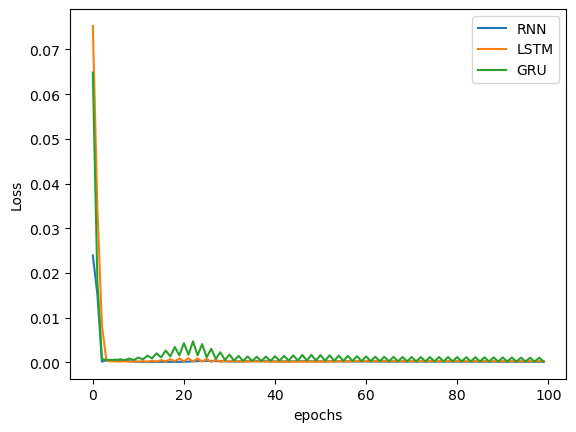

In [31]:
plt.plot(rnn_train_losses,label='RNN')
plt.plot(lstm_train_losses,label='LSTM')
plt.plot(gru_train_losses,label='GRU')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.legend()

### Model Prediction

In [32]:
def predict(model, data_loader):
    model.eval()  
    predictions = []
    with torch.no_grad():
        for data, _ in data_loader:
            output = model(data)
            predictions.extend(output.view(-1).tolist())
    return predictions
    
def plot_training_predictions(train_preds, train_targets, title):
    plt.figure(figsize=(7.5, 5))
    r2 = r2_score(train_preds, train_targets)

    plt.plot(train_targets, label='Actual')
    plt.plot(train_preds, label='Predicted')
    plt.title(f'{title} - Training' + ' r2 score=' + str(r2))
    plt.legend()

    plt.show()

def plot_validation_predictions(valid_preds, valid_targets, title):
    plt.figure(figsize=(7.5, 5))
    r2 = r2_score(valid_preds, valid_targets)

    plt.plot(valid_targets, label='Actual')
    plt.plot(valid_preds, label='Predicted')
    plt.title(f'{title} - Validation' + ' r2 score=' + str(r2))
    plt.legend()
    plt.show()


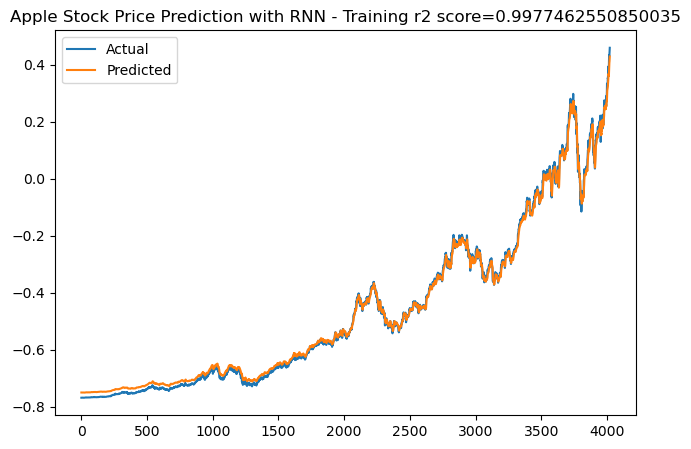

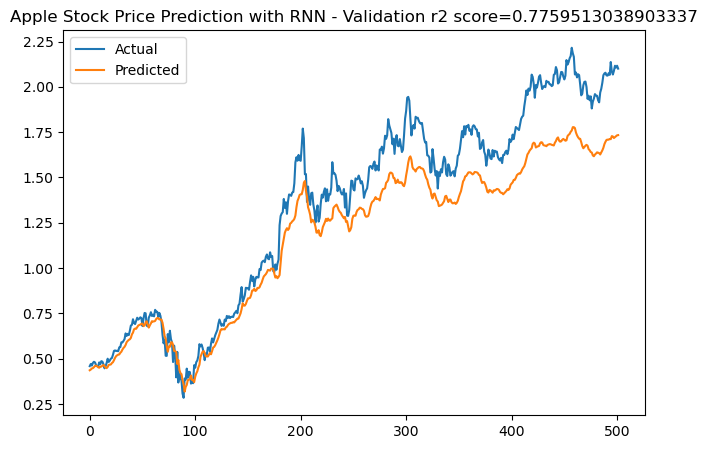

In [33]:
rnn_train_preds = predict(rnn_model, train_loader)
rnn_valid_preds = predict(rnn_model, valid_loader)

plot_training_predictions(rnn_train_preds, y_train.tolist(), "Apple Stock Price Prediction with RNN")
plot_validation_predictions(rnn_valid_preds, y_valid.tolist(), "Apple Stock Price Prediction with RNN")

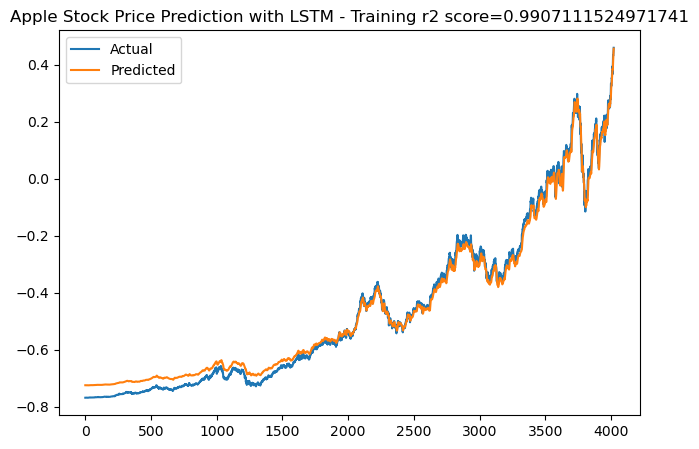

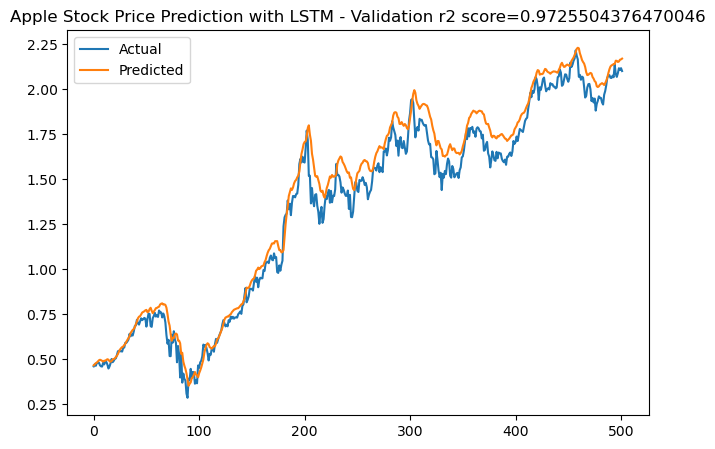

In [34]:
lstm_train_preds = predict(lstm_model, train_loader)
lstm_valid_preds = predict(lstm_model, valid_loader)

plot_training_predictions(lstm_train_preds, y_train.tolist(), "Apple Stock Price Prediction with LSTM")
plot_validation_predictions(lstm_valid_preds, y_valid.tolist(), "Apple Stock Price Prediction with LSTM")

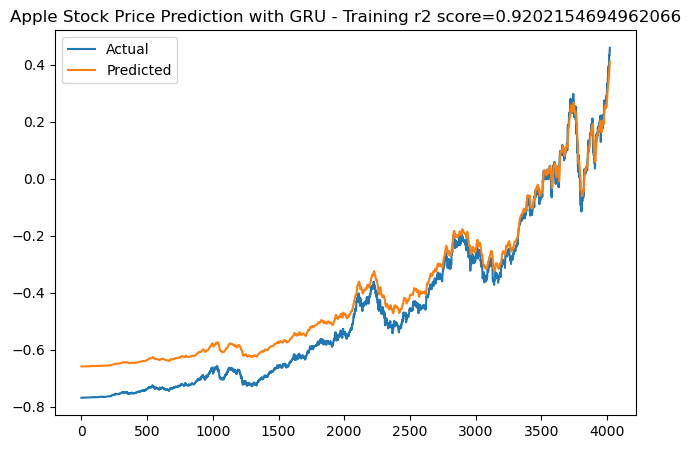

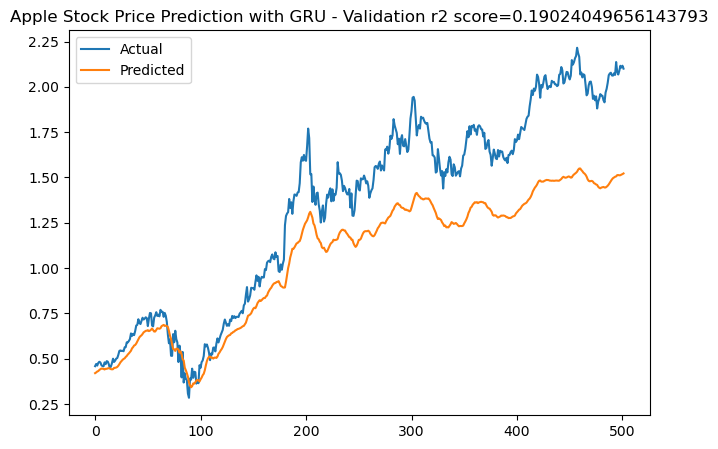

In [35]:
gru_train_preds = predict(gru_model, train_loader)
gru_valid_preds = predict(gru_model, valid_loader)

plot_training_predictions(gru_train_preds, y_train.tolist(), "Apple Stock Price Prediction with GRU")
plot_validation_predictions(gru_valid_preds, y_valid.tolist(), "Apple Stock Price Prediction with GRU")